                  t  Linear Acceleration x (m/s^2)  \
count  73959.000000                   73959.000000   
mean     194.430982                      -0.023652   
std      100.701386                       2.237656   
min       20.003044                     -13.379210   
25%      107.224690                      -0.955540   
50%      194.435856                       0.027918   
75%      281.640112                       1.058670   
max      368.837909                      12.286167   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                   73959.000000                   73959.000000  
mean                       -0.054390                      -0.008842  
std                         2.934934                       3.227174  
min                        -9.618012                     -18.348227  
25%                        -2.195258                      -1.398450  
50%                        -0.048232                      -0.102519  
75%                    

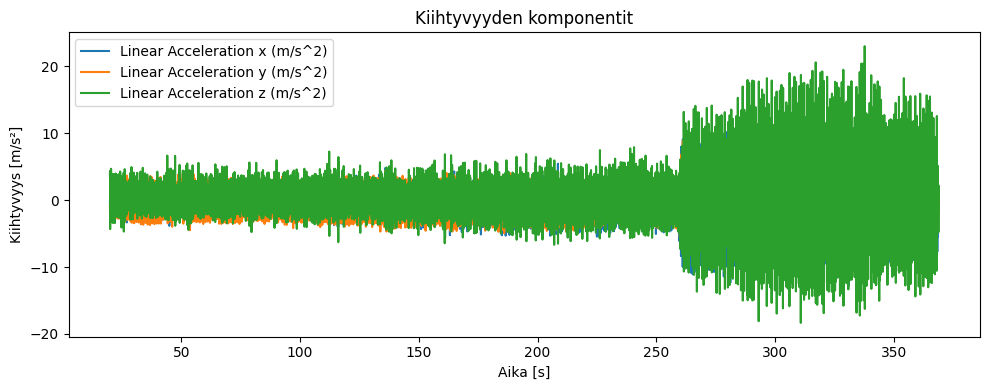

Arvioitu fs: 212.01713098441988 Hz
Askelmäärä: 672


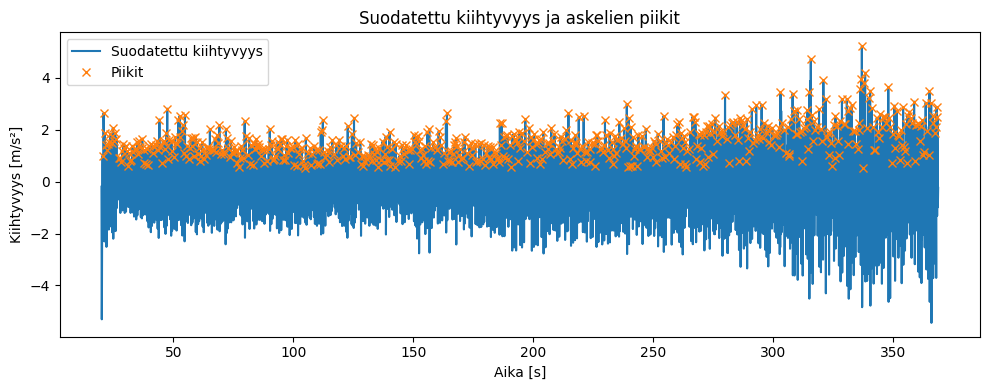

Dominoiva taajuus: 4.348007569016423 Hz
Askelmäärä (Fourier-analyysi): 1516.7366341829436
Kuljettu matka: 713.3698844535049 m
Keskinopeus: 2.0499101598343508 m/s
Keskinopeus: 7.379676575403663 km/h
Askelpituus: 1.0615623280558109 m/askel


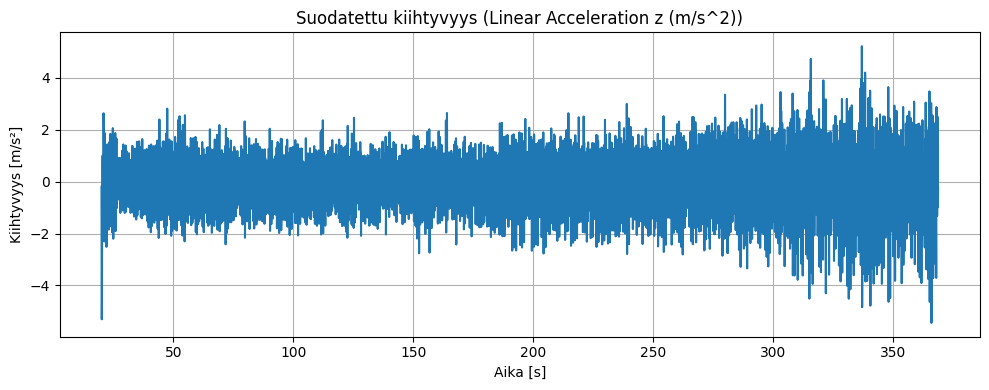

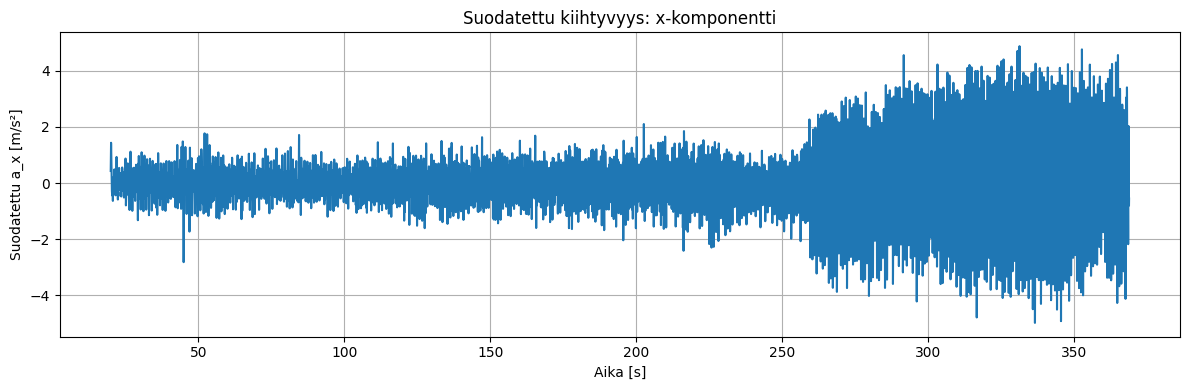

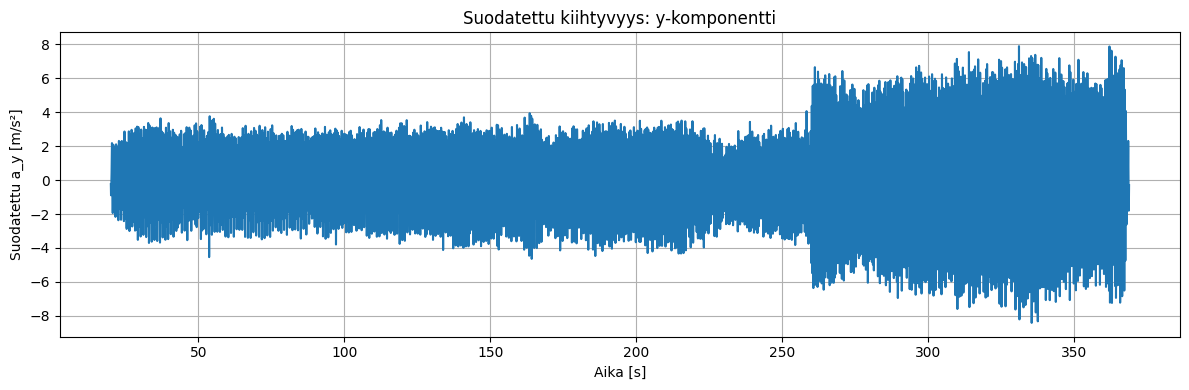

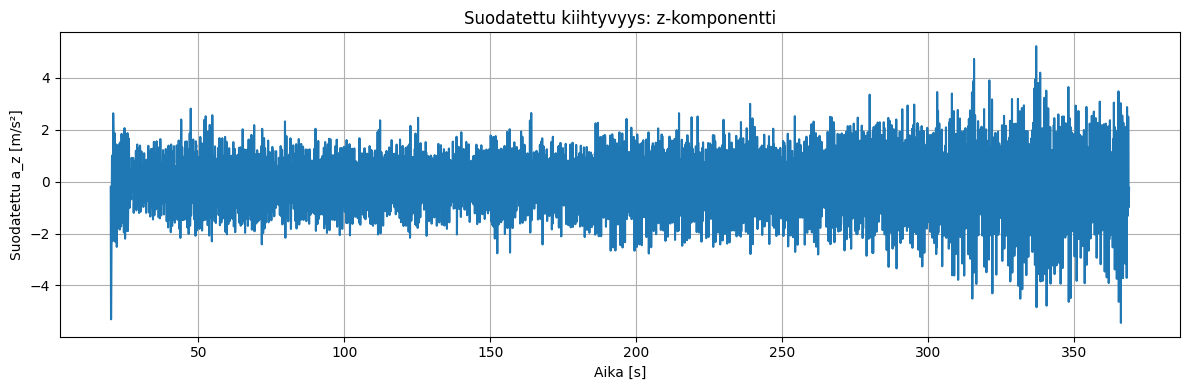

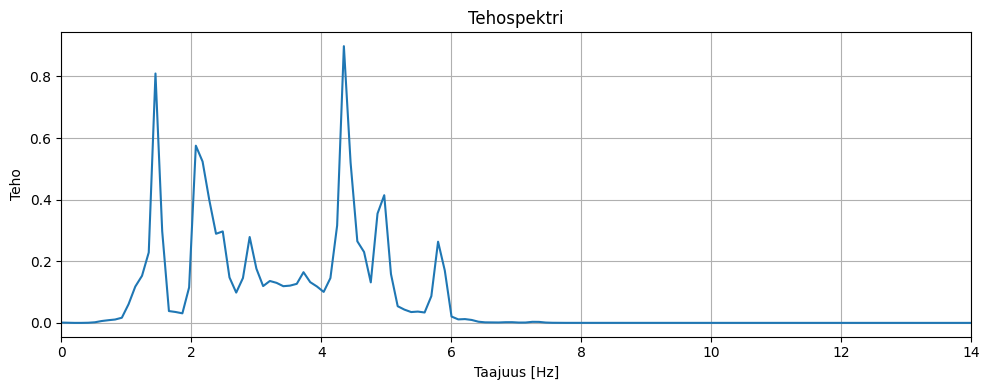

Kartta tallennettu tiedostoon fig_05_reitti_taustakartalla.html

Yhteenvetotaulukko:

                                     Suure         Arvo
0       Askelmäärä (aikadomain, piikeistä)   672.000000
1  Askelmäärä (Fourier, dominoiva taajuus)  1516.736634
2                       Kuljettu matka [m]   713.369884
3                        Keskinopeus [m/s]     2.049910
4                       Keskinopeus [km/h]     7.379677
5                    Askelpituus [m/askel]     1.061562
6                   Dominoiva taajuus [Hz]     4.348008
7                     Mittauksen kesto [s]   348.834865


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

from scipy.signal import butter, filtfilt, find_peaks, welch

#Kiihtyvyys
acc_path = "data/Accelerometer.csv"

acc = pd.read_csv(acc_path, comment="#", sep=",")
#print(acc.head())
#print(acc.columns)

#GPS
loc_path = "data/Location.csv"

loc = pd.read_csv(loc_path, comment="#", sep=",")
#print(loc.head())
#print(loc.columns)

#ajan valinta
acc_time_col = "Time (s)"
loc_time_col = "Time (s)"

#Aikaleimojen normalisointi
#Aika sekunteina, alkaen nollasta
acc["t"] = acc[acc_time_col] - acc[acc_time_col].iloc[0]
loc["t"] = loc[loc_time_col] - loc[loc_time_col].iloc[0]

#Trimmataan alkupäätä mittausvirheen poistamiseksi kun seison paikallani
t_cut = 20.0

acc = acc[acc["t"] >= t_cut].reset_index(drop=True)
loc = loc[loc["t"] >= t_cut].reset_index(drop=True)

ax_col = "Linear Acceleration x (m/s^2)"
ay_col = "Linear Acceleration y (m/s^2)"
az_col = "Linear Acceleration z (m/s^2)"

acc_subset = acc[["t", ax_col, ay_col, az_col]].copy()

print(acc_subset.describe())

#Piirretään kaikki komponentit tutkimista varten
plt.figure(figsize=(10, 4))
plt.plot(acc_subset["t"], acc_subset[ax_col], label=ax_col)
plt.plot(acc_subset["t"], acc_subset[ay_col], label=ay_col)
plt.plot(acc_subset["t"], acc_subset[az_col], label=az_col)
plt.xlabel("Aika [s]")
plt.ylabel("Kiihtyvyys [m/s²]")
plt.legend()
plt.title("Kiihtyvyyden komponentit")
plt.tight_layout()
plt.show()

selected_axis = az_col
acc["a_sel"] = acc[selected_axis]

#Suodatus ja askelmäärä
dt = acc["t"].diff().median()
fs = 1.0 / dt
print("Arvioitu fs:", fs, "Hz")

# Bandpass 0.5–5 Hz (askeltaajuusalue)
low = 0.5 / (fs / 2.0)
high = 5.0 / (fs / 2.0)
order = 4

b, a = butter(order, [low, high], btype="band")
acc["ax_filt"] = filtfilt(b, a, acc[ax_col])
acc["ay_filt"] = filtfilt(b, a, acc[ay_col])
acc["az_filt"] = filtfilt(b, a, acc[az_col])
acc["a_filt"] = filtfilt(b, a, acc["a_sel"])

peak_height = np.std(acc["a_filt"]) * 0.5   # karkea lähtökohta
min_distance_seconds = 0.3                  # vähintään 0.3 s välissä
min_distance_samples = int(min_distance_seconds * fs)

peaks, properties = find_peaks(
    acc["a_filt"],
    height=peak_height,
    distance=min_distance_samples
)

step_count_time = len(peaks)
print("Askelmäärä:", step_count_time)

#Visualisointi
plt.figure(figsize=(10, 4))
plt.plot(acc["t"], acc["a_filt"], label="Suodatettu kiihtyvyys")
plt.plot(acc["t"].iloc[peaks], acc["a_filt"].iloc[peaks], "x", label="Piikit")
plt.xlabel("Aika [s]")
plt.ylabel("Kiihtyvyys [m/s²]")
plt.legend()
plt.title("Suodatettu kiihtyvyys ja askelien piikit")
plt.tight_layout()
plt.show()

# Tehospektritiheys
x = acc["a_filt"].to_numpy()

f, Pxx = welch(
    x,
    fs=fs,
    nperseg=min(2048, len(x))
)

# Dominoiva taajuus askelalueella
freq_min = 0.5
freq_max = 5.0
mask = (f >= freq_min) & (f <= freq_max)
f_region = f[mask]
P_region = Pxx[mask]

dominant_idx = np.argmax(P_region)
dominant_freq = f_region[dominant_idx]
duration = acc["t"].iloc[-1] - acc["t"].iloc[0]
step_count_freq = dominant_freq * duration

print("Dominoiva taajuus:", dominant_freq, "Hz")
print("Askelmäärä (Fourier-analyysi):", step_count_freq)

def haversine(lat1, lon1, lat2, lon2):
    """
    Laskee etäisyyden metreinä kahden pisteen välillä.
    Lat/Lon asteina.
    """
    R = 6371e3  # maapallon säde metreinä

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

lat_col = "Latitude (°)"
lon_col = "Longitude (°)"

loc["lat"] = loc[lat_col]
loc["lon"] = loc[lon_col]

# Etäisyys pisteiden välien perusteetlla
distances = haversine(
    loc["lat"].values[:-1],
    loc["lon"].values[:-1],
    loc["lat"].values[1:],
    loc["lon"].values[1:]
)

total_distance = np.sum(distances)
print("Kuljettu matka:", total_distance, "m")

#Keskinopeus
gps_duration = loc["t"].iloc[-1] - loc["t"].iloc[0]

mean_speed = total_distance / gps_duration
mean_speed_kmh = mean_speed * 3.6

print("Keskinopeus:", mean_speed, "m/s")
print("Keskinopeus:", mean_speed_kmh, "km/h")

#Askelpituus 
steps_for_stride = step_count_time

step_length = total_distance / steps_for_stride  # metreinä per askel
print("Askelpituus:", step_length, "m/askel")

#RAPORTTI
#Suodatettu kiihtyvyys
plt.figure(figsize=(10, 4))
plt.plot(acc["t"], acc["a_filt"])
plt.xlabel("Aika [s]")
plt.ylabel("Kiihtyvyys [m/s²]")
plt.title(f"Suodatettu kiihtyvyys ({selected_axis})")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(acc["t"], acc["ax_filt"])
plt.title("Suodatettu kiihtyvyys: x-komponentti")
plt.xlabel("Aika [s]")
plt.ylabel("Suodatettu a_x [m/s²]")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(acc["t"], acc["ay_filt"])
plt.title("Suodatettu kiihtyvyys: y-komponentti")
plt.xlabel("Aika [s]")
plt.ylabel("Suodatettu a_y [m/s²]")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(acc["t"], acc["az_filt"])
plt.title("Suodatettu kiihtyvyys: z-komponentti")
plt.xlabel("Aika [s]")
plt.ylabel("Suodatettu a_z [m/s²]")
plt.grid(True)
plt.tight_layout()
plt.show()

#Tehospektritiheys
plt.figure(figsize=(10, 4))
plt.plot(f, Pxx)
plt.xlim(0, 14)
plt.xlabel("Taajuus [Hz]")
plt.ylabel("Teho")
plt.title("Tehospektri")
plt.grid(True)
plt.tight_layout()
plt.savefig("fig_02_tehospektri.png", dpi=300, bbox_inches="tight")
plt.show()

# Reitti kartalla

center_lat = loc["Latitude (°)"].mean()
center_lon = loc["Longitude (°)"].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles="OpenStreetMap"
)

route_coords = list(zip(loc["Latitude (°)"], loc["Longitude (°)"]))

folium.PolyLine(
    route_coords,
    color="red",
    weight=4,
    opacity=0.9
).add_to(m)

#Alku ja loppupisteet
folium.Marker(
    route_coords[0],
    tooltip="Lähtö"
).add_to(m)

folium.Marker(
    route_coords[-1],
    tooltip="Loppu"
).add_to(m)

m
m.save("fig_05_reitti_taustakartalla.html")
print("Kartta tallennettu tiedostoon fig_05_reitti_taustakartalla.html")

summary = pd.DataFrame(
    {
        "Suure": [
            "Askelmäärä (aikadomain, piikeistä)",
            "Askelmäärä (Fourier, dominoiva taajuus)",
            "Kuljettu matka [m]",
            "Keskinopeus [m/s]",
            "Keskinopeus [km/h]",
            "Askelpituus [m/askel]",
            "Dominoiva taajuus [Hz]",
            "Mittauksen kesto [s]"
        ],
        "Arvo": [
            step_count_time,
            step_count_freq,
            total_distance,
            mean_speed,
            mean_speed_kmh,
            step_length,
            dominant_freq,
            duration
        ]
    }
)

print("\nYhteenvetotaulukko:\n")
print(summary)
